In [1]:
# https://emcee.readthedocs.io/en/stable/tutorials/line/

In [1]:
# same as 'simple-regression.ipynb' but using tfd
# for the prior

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [2]:
# from tensorflow_probability.substrates import jax as tfp
# tfd = tfp.distributions

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.size": 16})

In [19]:
import scipy

In [4]:
np.random.seed(123)

In [5]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [6]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

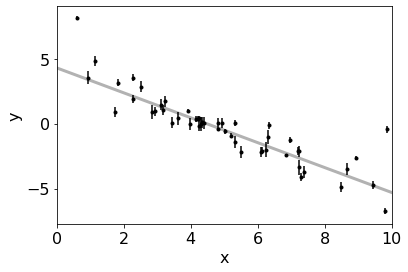

In [7]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [8]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, np.newaxis])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))

In [9]:
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


In [10]:
np.sqrt(cov[0, 0])

0.016229892552329792

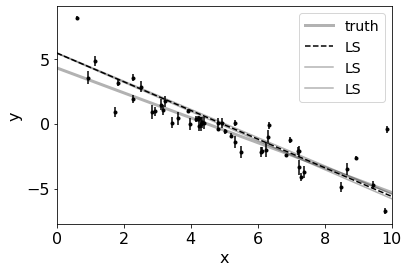

In [11]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")

w_low = w - np.sqrt(cov[0, 0])
w_high = w + np.sqrt(cov[0, 0])

plt.plot(x0, np.dot(np.vander(x0, 2), w_low), "k", label="LS", alpha=0.3)
plt.plot(x0, np.dot(np.vander(x0, 2), w_high), "k", label="LS", alpha=0.3)


plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [12]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [13]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


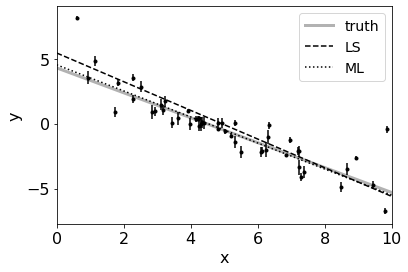

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [20]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0 # exp(0) = 0
    return -np.inf # exp(-inf) = 1

In [21]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf # exp(-inf) = 1
    return lp + log_likelihood(theta, x, y, yerr)

In [22]:
scipy_prior_m_func = scipy.stats.uniform(-5, 10)
scipy_prior_b_func = scipy.stats.uniform(0, 10)
scipy_prior_log_f_func = scipy.stats.uniform(-10, 20)

In [23]:
def scipy_log_prior(theta):
    m, b, log_f = theta
    prior_m = scipy_prior_m_func.logpdf(m)
    prior_b = scipy_prior_b_func.logpdf(b)
    prior_log_f = scipy_prior_log_f_func.logpdf(log_f)
    
    return prior_m + prior_b + prior_log_f

In [24]:
def scipy_log_probability(theta, x, y, yerr):
    lp = scipy_log_prior(theta)
    return lp + log_likelihood(theta, x, y, yerr)

In [25]:
tf_prior_m_func = tfd.Uniform(-5., 5.)
tf_prior_b_func = tfd.Uniform(0., 10.)
tf_prior_log_f_func = tfd.Uniform(-10., 10.)

In [26]:
def tf_log_prior(theta):
    m, b, log_f = theta
    prior_m = tf_prior_m_func.log_prob([m])
    prior_b = tf_prior_b_func.log_prob([b])
    prior_log_f = tf_prior_log_f_func.log_prob([log_f])
    
    return prior_m + prior_b + prior_log_f

In [45]:
%%timeit
log_prior([1,1,1])

189 ns ± 2.86 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [44]:
%%timeit
scipy_log_prior([1,1,1])

242 µs ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
%%timeit
tf_log_prior([1,1,1])

5.88 ms ± 61.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
def tf_log_probability(theta, x, y, yerr):
    lp = tf_log_prior(theta)
    return lp + log_likelihood(theta, x, y, yerr)

In [36]:
tf_log_probability([1,1,1], x, y, yerr)

DeviceArray([-148.02222], dtype=float32)

In [37]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [38]:
emcee.__version__

'3.0.2'

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

# sampler = emcee.EnsembleSampler(nwalkers, ndim, scipy_log_probability, args=(x, y, yerr))
# sampler.run_mcmc(pos, 5000, progress=True);

# sampler = emcee.EnsembleSampler(nwalkers, ndim, tf_log_probability, args=(x, y, yerr))
# sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:04<00:00, 1007.73it/s]


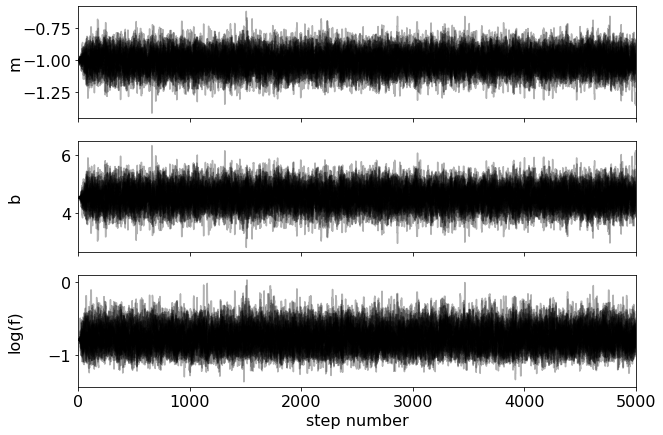

In [115]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [116]:
tau = sampler.get_autocorr_time()
print(tau)

[38.95709361 39.08920597 37.79283401]


In [117]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [118]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [119]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [24]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>